In [1]:
import pandas as pd
import os
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

In [2]:
BASE_PATH = r"C:\Users\fdcontreras\OneDrive - Indra\Universidad\Despliegue de Soluciones Analíticas\Proyecto_Despliegue\Proyecto_Despliegue\data\01_raw"

def load_datasets():
    files = {
        'orders': 'olist_orders_dataset.csv',
        'order_items': 'olist_order_items_dataset.csv',
        'customers': 'olist_customers_dataset.csv',
        'products': 'olist_products_dataset.csv',
        'sellers': 'olist_sellers_dataset.csv',
        'order_payments': 'olist_order_payments_dataset.csv',
        'order_reviews': 'olist_order_reviews_dataset.csv',
        'geolocation': 'olist_geolocation_dataset.csv',
        'product_translation': 'product_category_name_translation.csv'
    }
    
    datasets = {}
    for name, filename in files.items():
        filepath = os.path.join(BASE_PATH, filename)
        datasets[name] = pd.read_csv(filepath)
    
    return datasets

data = load_datasets()

In [ ]:

for name, df in data.items():
    print(f"{name}: {df.shape}")

orders: (99441, 8)
order_items: (112650, 7)
customers: (99441, 5)
products: (32951, 9)
sellers: (3095, 4)
order_payments: (103886, 5)
order_reviews: (99224, 7)
geolocation: (1000163, 5)
product_translation: (71, 2)


In [4]:
# Merge principal: orders como tabla central
merged_df = data['orders'].merge(
    data['order_items'], 
    on='order_id', 
    how='left'
)

print(f"Después de order_items: {merged_df.shape}")

Después de order_items: (113425, 14)


In [5]:
# Agregar información de productos
merged_df = merged_df.merge(
    data['products'], 
    on='product_id', 
    how='left'
)

print(f"Después de products: {merged_df.shape}")

Después de products: (113425, 22)


In [6]:
# Agregar traducción de categorías
merged_df = merged_df.merge(
    data['product_translation'], 
    on='product_category_name', 
    how='left'
)

print(f"Después de product_translation: {merged_df.shape}")

Después de product_translation: (113425, 23)


In [7]:
# Agregar información de vendedores
merged_df = merged_df.merge(
    data['sellers'], 
    on='seller_id', 
    how='left'
)

print(f"Después de sellers: {merged_df.shape}")

Después de sellers: (113425, 26)


In [8]:
# Agregar información de clientes
merged_df = merged_df.merge(
    data['customers'], 
    on='customer_id', 
    how='left'
)

print(f"Después de customers: {merged_df.shape}")

Después de customers: (113425, 30)


In [9]:
# Agregar pagos
merged_df = merged_df.merge(
    data['order_payments'], 
    on='order_id', 
    how='left'
)

print(f"Después de order_payments: {merged_df.shape}")

Después de order_payments: (118434, 34)


In [10]:
# Agregar reviews
merged_df = merged_df.merge(
    data['order_reviews'], 
    on='order_id', 
    how='left'
)

print(f"Después de order_reviews: {merged_df.shape}")

Después de order_reviews: (119143, 40)


In [11]:
# Agregar geolocalización de clientes
customer_geo = data['geolocation'].drop_duplicates(subset=['geolocation_zip_code_prefix'])
customer_geo = customer_geo.rename(columns={
    'geolocation_zip_code_prefix': 'customer_zip_code_prefix',
    'geolocation_lat': 'customer_lat',
    'geolocation_lng': 'customer_lng',
    'geolocation_city': 'customer_geo_city',
    'geolocation_state': 'customer_geo_state'
})

merged_df = merged_df.merge(
    customer_geo, 
    on='customer_zip_code_prefix', 
    how='left'
)

print(f"Después de customer geolocation: {merged_df.shape}")

Después de customer geolocation: (119143, 44)


In [12]:
# Agregar geolocalización de vendedores
seller_geo = data['geolocation'].drop_duplicates(subset=['geolocation_zip_code_prefix'])
seller_geo = seller_geo.rename(columns={
    'geolocation_zip_code_prefix': 'seller_zip_code_prefix',
    'geolocation_lat': 'seller_lat',
    'geolocation_lng': 'seller_lng',
    'geolocation_city': 'seller_geo_city',
    'geolocation_state': 'seller_geo_state'
})

merged_df = merged_df.merge(
    seller_geo, 
    on='seller_zip_code_prefix', 
    how='left'
)

print(f"Dataset final: {merged_df.shape}")

Dataset final: (119143, 48)


In [13]:
# Verificar información del dataset final
print("Información del dataset consolidado:")
print(f"Filas: {merged_df.shape[0]:,}")
print(f"Columnas: {merged_df.shape[1]}")
print(f"Memoria: {merged_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Información del dataset consolidado:
Filas: 119,143
Columnas: 48
Memoria: 224.90 MB


In [14]:
# Mostrar primeras filas
merged_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,review_creation_date,review_answer_timestamp,customer_lat,customer_lng,customer_geo_city,customer_geo_state,seller_lat,seller_lng,seller_geo_city,seller_geo_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,2017-10-11 00:00:00,2017-10-12 03:43:48,-23.574809,-46.587471,sao paulo,SP,-23.680114,-46.452454,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,2017-10-11 00:00:00,2017-10-12 03:43:48,-23.574809,-46.587471,sao paulo,SP,-23.680114,-46.452454,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,2017-10-11 00:00:00,2017-10-12 03:43:48,-23.574809,-46.587471,sao paulo,SP,-23.680114,-46.452454,maua,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,...,2018-08-08 00:00:00,2018-08-08 18:37:50,-12.169860,-44.988369,barreiras,BA,-19.810119,-43.984727,belo horizonte,MG
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,...,2018-08-18 00:00:00,2018-08-22 19:07:58,-16.746337,-48.514624,vianopolis,GO,-21.362358,-48.232976,guariba,SP


In [15]:
# Exportar dataset consolidado
output_path = os.path.join(BASE_PATH, '..', '02_processed', 'olist_consolidated_dataset.csv')
os.makedirs(os.path.dirname(output_path), exist_ok=True)

merged_df.to_csv(output_path, index=False)
print(f"Dataset exportado a: {output_path}")

Dataset exportado a: C:\Users\fdcontreras\OneDrive - Indra\Universidad\Despliegue de Soluciones Analíticas\Proyecto_Despliegue\Proyecto_Despliegue\data\01_raw\..\02_processed\olist_consolidated_dataset.csv


In [16]:
# Convertir fechas a datetime
merged_df['order_purchase_timestamp'] = pd.to_datetime(merged_df['order_purchase_timestamp'])
merged_df['order_date'] = merged_df['order_purchase_timestamp'].dt.date

In [17]:
# Analizar días únicos de compra por categoría
category_days = merged_df.groupby('product_category_name_english')['order_date'].nunique().reset_index()
category_days.columns = ['product_category_name_english', 'unique_days']
category_days = category_days.sort_values('unique_days', ascending=False)

print("Categorías por días únicos de compra:")
print(category_days)

Categorías por días únicos de compra:
   product_category_name_english  unique_days
39               furniture_decor          607
65                sports_leisure          603
43                 health_beauty          602
7                 bed_bath_table          598
15         computers_accessories          593
..                           ...          ...
3          arts_and_craftmanship           21
52                    la_cuisine           13
11             cds_dvds_musicals           12
29     fashion_childrens_clothes            8
61         security_and_services            2

[71 rows x 2 columns]


In [18]:
# Filtrar categorías con más de 30 días únicos
valid_categories = category_days[category_days['unique_days'] > 30]['product_category_name_english'].tolist()
df_filtered = merged_df[merged_df['product_category_name_english'].isin(valid_categories)].copy()

print(f"Categorías válidas: {len(valid_categories)}")
print(f"Dataset filtrado: {df_filtered.shape}")

Categorías válidas: 62
Dataset filtrado: (116378, 49)


In [ ]:

sales_data = df_filtered.groupby(['product_category_name_english', 'order_date']).agg({
    'order_item_id': 'count',
    'price': 'sum',
    'freight_value': 'sum'
}).reset_index()

sales_data.columns = ['category', 'date', 'items_sold', 'revenue', 'freight_total']
sales_data['date'] = pd.to_datetime(sales_data['date'])

print(f"Dataset de ventas para modelado: {sales_data.shape}")
sales_data.head()

Dataset de ventas para modelado: (18325, 5)


,category,date,items_sold,revenue,freight_total
0,agro_industry_and_commerce,2017-01-23,2,43.98,17.44
1,agro_industry_and_commerce,2017-01-31,1,21.99,24.35
2,agro_industry_and_commerce,2017-02-05,1,21.99,14.52
3,agro_industry_and_commerce,2017-02-08,1,21.99,17.78
4,agro_industry_and_commerce,2017-02-12,1,92.90,20.97


### Random Forest

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from joblib import dump
from IPython.display import display

In [ ]:
sales_data = (
    df_filtered
    .groupby(['product_category_name_english', 'order_date'])
    .agg(
        items_sold    = ('order_item_id', 'count'),
        revenue       = ('price',          'sum'),
        freight_total = ('freight_value',  'sum')
    )
    .reset_index()
)
sales_data.columns = ['category','date','items_sold','revenue','freight_total']
sales_data['date'] = pd.to_datetime(sales_data['date'])

days_per_cat = (
    sales_data[sales_data['revenue'] > 0]
    .groupby('category')['date']
    .nunique()
)
valid_cats = days_per_cat[days_per_cat > 45].index.tolist()
sales_data = sales_data[sales_data['category'].isin(valid_cats)].copy()

def make_ts_features(ts, lags=(1,2,7), windows=(3,7)):
    df = pd.DataFrame({'date': ts.index})
    df['dow']   = ts.index.dayofweek
    df['month'] = ts.index.month
    for lag in lags:
        df[f'lag_{lag}'] = ts.shift(lag).values
    for w in windows:
        df[f'roll_mean_{w}'] = ts.shift(1).rolling(w).mean().values
    df = df.dropna().reset_index(drop=True)
    y = ts.shift(max(max(lags), max(windows))).dropna().values
    return df, y

n_test = 15
n_list = [50, 100, 200, 300, 400, 600]
summary = []

for cat in valid_cats:
    ts = (
        sales_data[sales_data['category'] == cat]
        .set_index('date')['revenue']
        .resample('D').sum()
    )
    X_all, y_all = make_ts_features(ts)
    X_train = X_all.iloc[:-n_test].drop(columns=['date'])
    X_test  = X_all.iloc[-n_test:].drop(columns=['date'])
    y_train = y_all[:-n_test]
    y_test  = y_all[-n_test:]
    if y_test.sum() == 0:
        continue


    oob_err = []
    for n in n_list:
        rf = RandomForestRegressor(
            n_estimators=n,
            oob_score=True,
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        oob_err.append(1 - rf.oob_score_)
    improvements = np.diff(oob_err)
    thresh       = -0.002
    idx          = np.where(improvements > thresh)[0]
    best_n       = n_list[idx[0]] if idx.size else n_list[-1]

    model = RandomForestRegressor(
        n_estimators=best_n,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    dump(model, f"models/rf_{cat}.joblib")

    y_pred = model.predict(X_test)
    mae    = mean_absolute_error(y_test, y_pred)
    rmse   = np.sqrt(mean_squared_error(y_test, y_pred))
    mask   = y_test != 0
    mape   = (np.abs((y_test[mask] - y_pred[mask]) / y_test[mask]).mean()) * 100

    summary.append({
        'category': cat,
        'best_n':   best_n,
        'MAE':      mae,
        'RMSE':     rmse,
        'MAPE (%)': mape
    })

df_best = pd.DataFrame(summary)[['category','best_n']].sort_values('category')
print("Mejor n_estimators por categoría:")
print(df_best.to_string(index=False))



Mejor n_estimators por categoría:
                               category  best_n
             agro_industry_and_commerce      50
                       air_conditioning      50
                                    art     100
                                  audio      50
                                   auto      50
                                   baby      50
                         bed_bath_table      50
                 books_general_interest      50
                         books_imported     100
                        books_technical      50
                     christmas_supplies      50
                             cine_photo      50
                              computers     100
                  computers_accessories      50
                         consoles_games      50
        construction_tools_construction      50
              construction_tools_lights      50
              construction_tools_safety     300
                             cool_stuff     100
      

In [ ]:
df_all = pd.DataFrame(summary)[['category','best_n','MAE','MAPE (%)']]
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

display(df_all)

,category,best_n,MAE,MAPE (%)
0,agro_industry_and_commerce,50,2.972800,5.299400
1,air_conditioning,50,6.585427,7.219181
2,art,100,0.487647,1.205188
3,audio,50,2.380947,1.082215
4,auto,50,225.373160,3.477956
5,baby,50,4.457533,0.582198
6,bed_bath_table,50,6.821360,0.230504
7,books_general_interest,50,0.565000,0.930243
8,books_imported,100,0.002867,0.172345
9,books_technical,50,2.561800,2.976568


In [50]:
stats = (
    sales_data
      .groupby('category')['revenue']
      .agg(mean_rev='mean', std_rev='std')
      .reset_index()
)

df_eval = pd.DataFrame(summary) \
    .merge(stats, on='category', how='left')

df_eval['NRMSE']    = df_eval['RMSE'] / df_eval['mean_rev']
df_eval['CV(RMSE)'] = df_eval['RMSE'] / df_eval['std_rev']

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
display(df_eval[['category','best_n','RMSE','mean_rev','NRMSE','CV(RMSE)']])


,category,best_n,RMSE,mean_rev,NRMSE,CV(RMSE)
0,agro_industry_and_commerce,50,8.149560,582.235764,0.013997,0.007662
1,air_conditioning,50,17.593998,282.638283,0.062249,0.056547
2,art,100,0.826473,161.581503,0.005115,0.001584
3,audio,50,6.306659,223.405404,0.028230,0.023699
4,auto,50,674.521368,1062.535223,0.634823,0.672615
5,baby,50,5.504117,773.722758,0.007114,0.006346
6,bed_bath_table,50,10.945647,1851.587107,0.005911,0.008675
7,books_general_interest,50,1.011004,156.994951,0.006440,0.005122
8,books_imported,100,0.011103,95.134314,0.000117,0.000098
9,books_technical,50,5.615935,112.348140,0.049987,0.066816


In [41]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

tscv = TimeSeriesSplit(n_splits=5)

for cat in valid_cats:
   
    if y_test.sum() == 0:
        continue

    param_dist = {
        'n_estimators': [best_n//2, best_n, best_n*2, best_n*3],
        'max_depth':    [None, 5, 10, 20, 30, 50],
        'min_samples_leaf': [1, 2, 5, 10, 20],
        'max_features': ['auto','sqrt','log2',0.3,0.5,0.8]
    }

    search = RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_distributions=param_dist,
        n_iter=50,                
        cv=tscv,                  
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=2,
        random_state=42
    )
    search.fit(X_train, y_train)

    best_params = search.best_params_
    print(f"{cat} → best_params: {best_params}")
    print(f"  CV MSE: {search.best_score_:.4f}")


    model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mae    = mean_absolute_error(y_test, y_pred)
    mask   = y_test != 0
    mape   = (np.abs((y_test[mask] - y_pred[mask]) / y_test[mask]).mean()) * 100

    summary.append({
        'category':   cat,
        'MAE':        mae,
        'MAPE (%)':   mape,
        **best_params
    })


Fitting 5 folds for each of 50 candidates, totalling 250 fits
agro_industry_and_commerce → best_params: {'n_estimators': 150, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': 30}
  CV MSE: -457416.5559
Fitting 5 folds for each of 50 candidates, totalling 250 fits
air_conditioning → best_params: {'n_estimators': 150, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': 30}
  CV MSE: -457416.5559
Fitting 5 folds for each of 50 candidates, totalling 250 fits
art → best_params: {'n_estimators': 150, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': 30}
  CV MSE: -457416.5559
Fitting 5 folds for each of 50 candidates, totalling 250 fits
audio → best_params: {'n_estimators': 150, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': 30}
  CV MSE: -457416.5559
Fitting 5 folds for each of 50 candidates, totalling 250 fits
auto → best_params: {'n_estimators': 150, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': 30}
  CV MSE: -457416.5559
Fitting 5 folds for each o

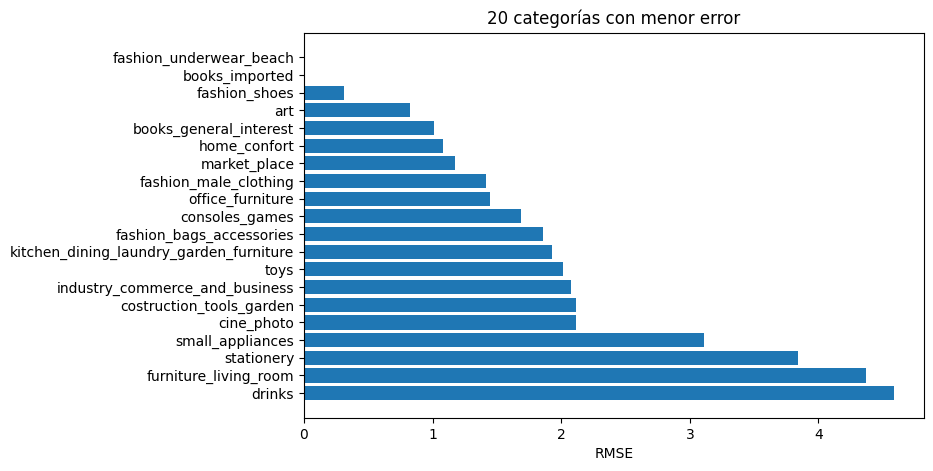

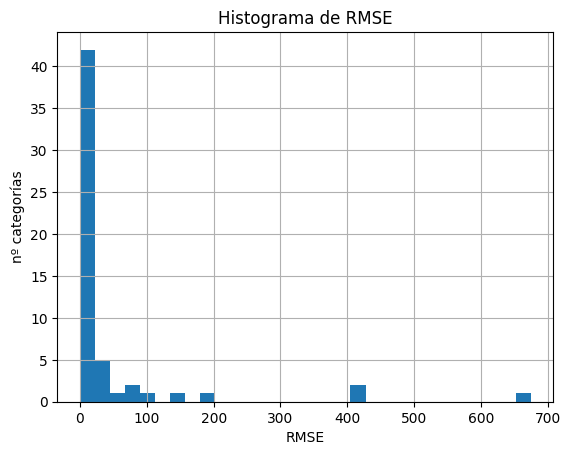

In [32]:
import matplotlib.pyplot as plt

# a) RMSE por categoría (top-20)
top20 = df_res.head(20)
plt.figure(figsize=(8,5))
plt.barh(top20['category'], top20['RMSE'])
plt.gca().invert_yaxis()
plt.xlabel("RMSE")
plt.title("20 categorías con menor error")
plt.show()

# b) Distribución global de RMSE
plt.figure()
df_res['RMSE'].hist(bins=30)
plt.xlabel("RMSE")
plt.ylabel("nº categorías")
plt.title("Histograma de RMSE")
plt.show()


In [23]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10]
}
tscv = TimeSeriesSplit(n_splits=3)
cat = 'electronics'
ts = sales_data[sales_data.category==cat]\
       .set_index('date')['revenue'].resample('D').sum()
X_all, y_all = make_ts_features(ts)
X = X_all.drop('date',axis=1);  y = y_all
gscv = GridSearchCV(RandomForestRegressor(random_state=42),
                    param_grid, cv=tscv, scoring='neg_root_mean_squared_error')
gscv.fit(X, y)
print("Best params for",cat,gscv.best_params_)


Best params for electronics {'max_depth': 10, 'n_estimators': 200}


In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# ── 0) Partimos de df_filtered que ya tiene:
#     ['product_category_name_english','order_date','order_item_id','price', ...]
#     y está filtrado por categorías con >30 días únicos de venta.

# ── 1) Construir ventas diarias por categoría
sales_data = (
    df_filtered
      .groupby(['product_category_name_english','order_date'])
      .agg({
          'order_item_id' : 'count',
          'price'         : 'sum',
          'freight_value' : 'sum'    # si quieres también el total de flete
      })
      .reset_index()
)
sales_data.columns = ['category','date','items_sold','revenue','freight_total']
sales_data['date'] = pd.to_datetime(sales_data['date'])

# ── 2) Filtrar categorías con >30 días con revenue>0
days_per_cat = (
    sales_data[sales_data['revenue'] > 0]
      .groupby('category')['date']
      .nunique()
      .loc[lambda x: x > 30]
)
valid_categories = days_per_cat.index.tolist()
sales_data = sales_data[sales_data['category'].isin(valid_categories)].copy()

# ── 3) Función de features (lags + rolling + calendario)
def make_features(ts, lags=[1,2,7], windows=[3,7]):
    df = pd.DataFrame({'revenue': ts})
    # rezagos
    for lag in lags:
        df[f'lag_{lag}'] = df['revenue'].shift(lag)
    # medias rodantes
    for w in windows:
        df[f'roll_mean_{w}'] = df['revenue'].shift(1).rolling(w).mean()
    # variables de calendario
    df['dow']   = ts.index.dayofweek
    df['month'] = ts.index.month
    df = df.dropna()
    y = df['revenue'].copy()
    X = df.drop(columns='revenue').copy()
    return X, y

# ── 4) Loop sobre categorías
results = []

n_test = 15  # últimos 15 días de test
for cat in valid_categories:
    # Serie diaria de revenue (llenando 0 en huecos)
    ts = (
        sales_data[sales_data['category']==cat]
        .set_index('date')['revenue']
        .resample('D').sum()
        .fillna(0)
    )

    # Features + target
    X, y = make_features(ts)

    # Split train / test
    X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]
    y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]

    # Saltar si en test no hubo ventas
    if y_test.sum() == 0:
        continue

    # Matrices para XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test,  label=y_test)

    # Hiperparámetros básicos
    params = {
        'objective': 'reg:squarederror',
        'eta':         0.05,
        'max_depth':   4,
        'seed':        42,
        'verbosity':   0
    }

    # Entrenamiento con early stopping
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=300,
        evals=[(dvalid, 'validation')],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    # Predicción y métricas
    y_pred = bst.predict(dvalid)
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.append({
        'category': cat,
        'MAE':       mae,
        'RMSE':      rmse
    })

# ── 5) Consolidar resultados y ordenar
df_metrics = (
    pd.DataFrame(results)
      .sort_values('RMSE')
      .reset_index(drop=True)
)
print(df_metrics)

                             category          MAE         RMSE
0                        dvds_blu_ray     8.214065     8.539942
1              tablets_printing_image    12.565124    14.739675
2              fashio_female_clothing    10.403256    23.781483
3   furniture_mattress_and_upholstery    15.795501    32.626368
4             fashion_underwear_beach    30.869676    41.217235
..                                ...          ...          ...
57                                art   390.847839   953.748864
58                      health_beauty  1273.049493  1511.794687
59                      watches_gifts  1274.361248  1704.471792
60                     sports_leisure  1309.350086  2107.598728
61                               auto  1306.731296  2166.573232

[62 rows x 3 columns]


In [33]:
df_metrics.sort_values("RMSE").head(10)   # las 10 con menor error


,category,MAE,RMSE
0,dvds_blu_ray,8.214065,8.539942
1,tablets_printing_image,12.565124,14.739675
2,fashio_female_clothing,10.403256,23.781483
3,furniture_mattress_and_upholstery,15.795501,32.626368
4,fashion_underwear_beach,30.869676,41.217235
5,fashion_male_clothing,37.353585,44.804129
6,books_general_interest,46.717402,51.164243
7,costruction_tools_tools,45.426380,55.049413
8,food_drink,43.130209,61.913997
9,cine_photo,40.179357,72.639300


In [34]:
df_metrics.sort_values("RMSE", ascending=False).head(10)  # las 10 peores

,category,MAE,RMSE
61,auto,1306.731296,2166.573232
60,sports_leisure,1309.350086,2107.598728
59,watches_gifts,1274.361248,1704.471792
58,health_beauty,1273.049493,1511.794687
57,art,390.847839,953.748864
56,construction_tools_construction,691.922745,911.607415
55,bed_bath_table,701.263807,896.303859
54,housewares,525.205390,674.371450
53,home_appliances_2,391.016359,637.107694
52,computers,492.886749,623.296871
